<a href="https://colab.research.google.com/github/AndreKaled/classificador-cao-gato/blob/main/classificador_cao_gato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descrição inicial
blabla isso classifica caes e gatinhos
# sumario pra acompanhar?


## Instalando dependências

In [39]:
!pip install LTNtorch kagglehub pandas

## Importando bibliotecas

In [40]:
import pandas as pd
import os
import warnings
import kagglehub
from kagglehub import KaggleDatasetAdapter
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import ltn
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Baixando dataset com imagens de cães e gatos

In [41]:
import kagglehub

# Baixa e extrai
dataset_name = "shaunthesheep/microsoft-catsvsdogs-dataset"
dataset_path = kagglehub.dataset_download(dataset_name)

print("Dataset baixado em:", dataset_path)


Using Colab cache for faster access to the 'microsoft-catsvsdogs-dataset' dataset.
Dataset baixado em: /kaggle/input/microsoft-catsvsdogs-dataset


### Explorando estrutura do dataset

In [42]:
print(os.listdir(dataset_path))

['PetImages', 'readme[1].txt', 'MSR-LA - 3467.docx']


In [43]:
main_folder_path = Path(dataset_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != dataset_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
microsoft-catsvsdogs-dataset,2
PetImages,0
Dog,12501
Cat,12501


In [44]:
print(f'Total {count.sum()}')

Total File Count    25004
dtype: int64


In [45]:
# mostra 5 imagens da classe
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

In [46]:
# entra na pasta certa, contendo as pastas com as imagens
print(os.listdir(os.path.join(dataset_path, 'PetImages')))
dataset_path = os.path.join(dataset_path, 'PetImages')

['Dog', 'Cat']


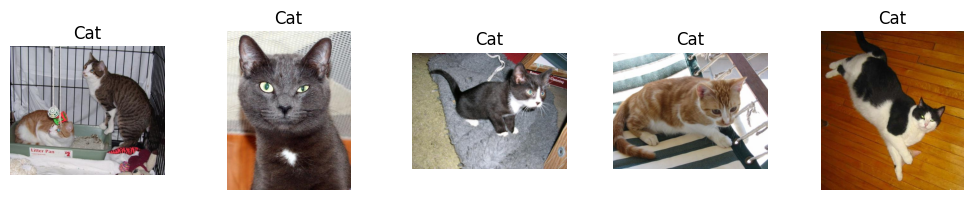

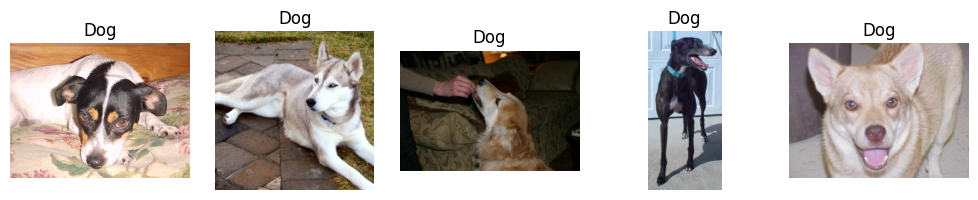

In [47]:
plot_imgs(dataset_path + '/Cat')
plot_imgs(dataset_path + '/Dog')

## Preparando DataLoader pra Pytorch

In [48]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # padroniza o tamanho de cada imagem
    transforms.ToTensor()
])

# dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform)

# dividindo em treino e validação
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Total de imagens:", len(dataset))
print("Treino:", len(train_dataset), " | Validação:", len(val_dataset))


Total de imagens: 25000
Treino: 21250  | Validação: 3750


## Preparando CNN


In [49]:
class CNNClassificador(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # camadas convolucionais: detectam padrões na imagem (bordas, texturas, formas)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # reduz resolução pela metade

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # flatten + fully connected: transforma padrões em saidas classificaveis
        self.fc1 = nn.Linear(128*28*28, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # convolução + ReLU + Pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # achata para passar pelas fully connected
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        # saida final: pontuação para cada classe
        x = self.fc3(x)
        return x

model = CNNClassificador(num_classes=2)
print(model)

CNNClassificador(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


## Preparando treino da CNN

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# função de perda padrão de classificacao binaria
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Lógica LTN

In [ ]:
# escrever a logica ltn aqui :)